In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2025-05-04 20:04:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-04 20:04:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-04 20:04:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch
import matplotlib.pyplot as plt
import optuna
import random
import seaborn as sns
import re, string, html

import torch.nn as nn #Base class for all neural network modules.
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Plots from HW1 to be used in the end
from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors, Word2Vec

from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/sample_submission.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/train_dataset.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/test_dataset.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/val_dataset.csv


2025-05-04 20:08:27.290653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746389307.555711      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746389307.634240      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set a random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load datasets
train_ds = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/train_dataset.csv')
val_ds = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/val_dataset.csv')
test_ds = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/test_dataset.csv')

# Check data is imported correctly
print(train_ds.head)

# Load GloVe Word Embeddings
glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'
glove2word2vec(glove_input_file, w2v_output_file) #convert GloVe vectors into the word2vec

w2v_model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

<bound method NDFrame.head of             ID                                               Text  Label
0       189385      @whoisralphie dude  I'm so bummed ur leaving!      0
1        58036  oh my god, a severed foot was foun in a wheely...      0
2       190139  I end up &quot;dog dialing&quot; sumtimes. Wha...      1
3        99313                         @_rachelx meeeee toooooo!       0
4       157825  I was hoping I could stay home and work today,...      0
...        ...                                                ...    ...
148383   99894  just love the jonas brothers  its tooo bad i w...      0
148384   61015  another day gone by....time is moving so fast...       0
148385   36598  fuck college, i'm just gonna marry rich. : fuc...      1
148386   83799    ZOMGZ NEW SONG FTW.  remember that night. &lt;3      1
148387  185558  http://twitpic.com/7mwrd - Arby's took down th...      0

[148388 rows x 3 columns]>


/tmp/ipykernel_13/3536791429.py:18: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, w2v_output_file) #convert GloVe vectors into the word2vec


In [4]:
# Data Preprocessing (from HW1)
tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocessing(text):
    # Decode HTML entities
    text = html.unescape(text)
    # Make text lowercase
    text = text.lower()
    # Change emails to xxx@email.com
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', 'xxx@email.com', text)
    # Remove Twitter usernames
    text = re.sub(r'@\w+', '', text)
    # Change URLs to xxx.link.com
    text = re.sub(r'https?://\S+|www\.\S+', 'httpxxx', text)
     # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove non-alphanumeric characters and emojis
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Replace repeating characters (3 or more) with just 2 letters
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    # Tokenize with TweetTokenizer
    tokens = tk.tokenize(text)
    # Define stopwords to filter out of tokens list
    stop_words = {'the', 'and', 'is', 'in', 'to', 'of', 'a', 'for', 'in', 'so',
                 'omg', 'dude', 'lol', 'my', 'for', 'on', 'you', 'it', 'me'}
    # Lemmatize
    tokens = [ lemmatizer.lemmatize(word) 
               for word in tokens]
                   #if word not in stop_words and word.isalpha()]
    
    return ' '.join(tokens)

train_ds['preprocessed_text'] = train_ds['Text'].apply(preprocessing)
val_ds['preprocessed_text'] = val_ds['Text'].apply(preprocessing)
test_ds['preprocessed_text'] = test_ds['Text'].apply(preprocessing)

print(train_ds.head)

<bound method NDFrame.head of             ID                                               Text  Label  \
0       189385      @whoisralphie dude  I'm so bummed ur leaving!      0   
1        58036  oh my god, a severed foot was foun in a wheely...      0   
2       190139  I end up &quot;dog dialing&quot; sumtimes. Wha...      1   
3        99313                         @_rachelx meeeee toooooo!       0   
4       157825  I was hoping I could stay home and work today,...      0   
...        ...                                                ...    ...   
148383   99894  just love the jonas brothers  its tooo bad i w...      0   
148384   61015  another day gone by....time is moving so fast...       0   
148385   36598  fuck college, i'm just gonna marry rich. : fuc...      1   
148386   83799    ZOMGZ NEW SONG FTW.  remember that night. &lt;3      1   
148387  185558  http://twitpic.com/7mwrd - Arby's took down th...      0   

                                        preprocessed_text

In [5]:
#Word To Vector
def text_to_vector(text, w2v_model):
    embedding_dim = w2v_model.vector_size
    tokens = text.split()
    vectors = [w2v_model[token] for token in tokens if token in w2v_model]

    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

In [6]:
# Apply vectorization to each dataset
train_vecs = train_ds['preprocessed_text'].apply(lambda x: text_to_vector(x, w2v_model))
val_vecs = val_ds['preprocessed_text'].apply(lambda x: text_to_vector(x, w2v_model))
test_vecs = test_ds['preprocessed_text'].apply(lambda x: text_to_vector(x, w2v_model))

# Convert to NumPy arrays
train_array = np.vstack(train_vecs.values)
val_array = np.vstack(val_vecs.values)
test_array = np.vstack(test_vecs.values)

# Convert to PyTorch tensors
X_train_vec = torch.tensor(train_array, dtype=torch.float32)
y_train_vec = torch.tensor(train_ds['Label'].values, dtype=torch.float32).unsqueeze(1)

X_val_vec = torch.tensor(val_array, dtype=torch.float32)
y_val_vec = torch.tensor(val_ds['Label'].values, dtype=torch.float32).unsqueeze(1)

X_test_vec = torch.tensor(test_array, dtype=torch.float32)

In [7]:
# Define Dataloaders
train_loader = DataLoader(TensorDataset(X_train_vec, y_train_vec), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_vec, y_val_vec), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test_vec), batch_size=64)

In [8]:
# Create the Neural Network

class SentimentClassifier(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(SentimentClassifier, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.output = nn.Linear(H3, D_out)
        
    def forward(self, x):
        h1 = torch.relu(self.linear1(x))
        h2 = torch.relu(self.linear2(h1))
        h3 = torch.relu(self.linear3(h2))
        #out = self.output(h3) # For BCEWithLogitsLoss()
        out = torch.sigmoid(self.output(h3)) # Applying sigmoid for BCELoss()
        return out

## Setup Model, Optimizer and Loss

# Define layer sizes
D_in = X_train_vec.shape[1]
H1, H2, H3 = 128, 64, 32 #256, 128, 64 # 512, 256, 128 
D_out = 1

# Define hyperparameters
learning_rate = 5e-4 # 1e-3 # 1e-4

# Instantiate model, loss, optimizer
model = SentimentClassifier(D_in, H1, H2, H3, D_out)
loss_func = nn.BCELoss(reduction='sum') # BCELoss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [9]:
# Train Model
train_accuracies = []
train_losses = []
val_losses = []
val_f1s = []
val_accuracies = []
model_outputs=[]
best_f1 = 0
best_model_state = None
patience_early_stopping = 5
epochs_no_improve = 0
best_epoch = 5

for epoch in range(30): # 30
    model.train()
    batch_losses = []

    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch)
        loss = loss_func(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    avg_train_loss = sum(batch_losses) / len(train_loader)
    train_losses.append(avg_train_loss)

    # Track training accuracy
    correct_train, total_train = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            y_pred = model(x_batch)
            preds = (y_pred >= 0.5).long()
            correct_train += (preds == y_batch).sum().item()
            total_train += y_batch.size(0)

    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # Evaluation on val set
    model.eval()
    val_batch_losses = []
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            val_loss = loss_func(output, y_batch)
            val_batch_losses.append(val_loss.item())
            
            preds = (output >= 0.5).long().squeeze()
            y_true.extend(y_batch.squeeze().tolist())
            y_pred.extend(preds.tolist())

    avg_val_loss = sum(val_batch_losses) / len(val_loader)
    val_losses.append(avg_val_loss)
    
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    val_f1s.append(f1)
    val_accuracies.append(acc)

    scheduler.step(val_loss)
    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict()
        best_epoch = epoch + 1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience_early_stopping:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    print(f"Epoch {epoch+1} "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {acc:.4f} | Val F1: {f1:.4f}")

# Load the best model before final eval
model.load_state_dict(best_model_state)

print("\nFinal Evaluation on Validation Set:")
model.eval()
y_true, y_pred, model_outputs = [], [], []
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        output = model(x_batch)
        model_outputs.extend(output.squeeze().tolist())
        preds = (output >= 0.5).long().squeeze()
        y_true.extend(y_batch.squeeze().tolist())
        y_pred.extend(preds.tolist())


print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive'], zero_division=0))
print(f"\nBest Validation F1 Score: {best_f1:.4f} in epoch {best_epoch}")

Epoch 1 Train Loss: 43.9248 | Val Loss: 41.0667 | Train Acc: 0.6710 | Val Acc: 0.6718 | Val F1: 0.6705
Epoch 2 Train Loss: 36.3687 | Val Loss: 34.8050 | Train Acc: 0.7223 | Val Acc: 0.7249 | Val F1: 0.7231
Epoch 3 Train Loss: 35.0157 | Val Loss: 34.1131 | Train Acc: 0.7307 | Val Acc: 0.7328 | Val F1: 0.7326
Epoch 4 Train Loss: 34.5064 | Val Loss: 33.7992 | Train Acc: 0.7346 | Val Acc: 0.7352 | Val F1: 0.7347
Epoch 5 Train Loss: 34.0985 | Val Loss: 34.6412 | Train Acc: 0.7196 | Val Acc: 0.7199 | Val F1: 0.7136
Epoch 6 Train Loss: 33.7147 | Val Loss: 33.2559 | Train Acc: 0.7401 | Val Acc: 0.7404 | Val F1: 0.7396
Epoch 7 Train Loss: 33.3708 | Val Loss: 33.0271 | Train Acc: 0.7467 | Val Acc: 0.7444 | Val F1: 0.7440
Epoch 8 Train Loss: 33.0844 | Val Loss: 32.9319 | Train Acc: 0.7458 | Val Acc: 0.7429 | Val F1: 0.7413
Epoch 9 Train Loss: 32.7671 | Val Loss: 32.9068 | Train Acc: 0.7497 | Val Acc: 0.7446 | Val F1: 0.7440
Epoch 10 Train Loss: 32.0363 | Val Loss: 32.2126 | Train Acc: 0.7588 | Va

In [10]:
metrics_df = pd.DataFrame({
    'epoch': list(range(1, len(train_losses)+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies,
    'val_f1': val_f1s
})
metrics_df.to_csv("training_metrics.csv", index=False)

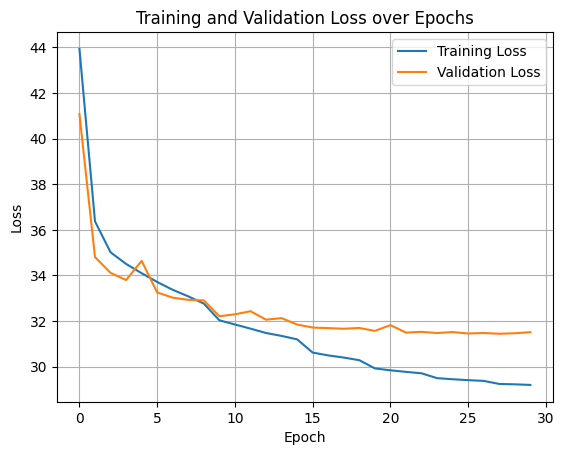

In [11]:
# Plots for Training Loss over Epochs
# Plot Training and Validation Loss over Epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.grid(True)
plt.legend()
plt.savefig("loss_over_epochs_dimensions.png")
plt.show()

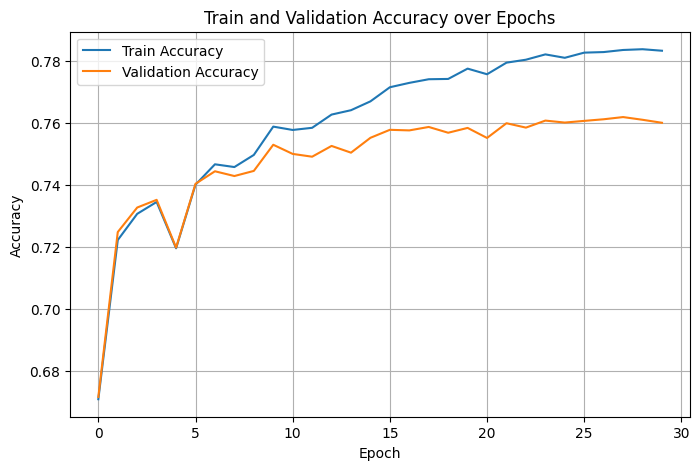

In [12]:
# Train and Val Accuracies over Epochs
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.savefig("accuracy over epochs dimensions.png")
plt.show()

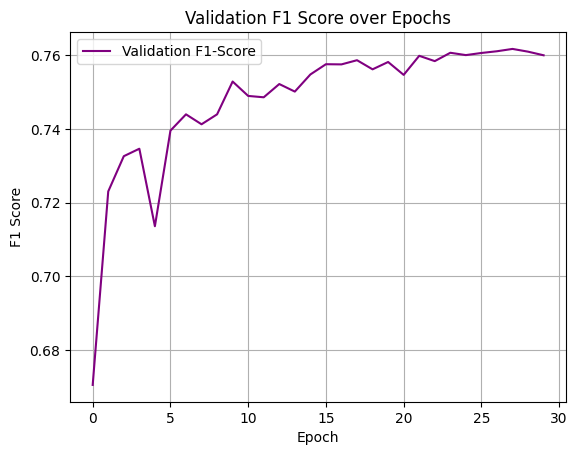

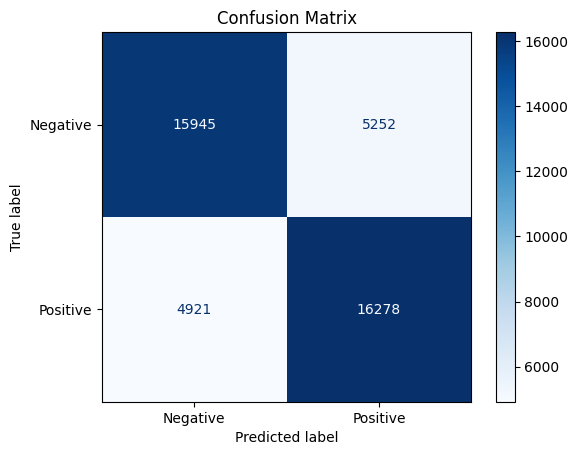

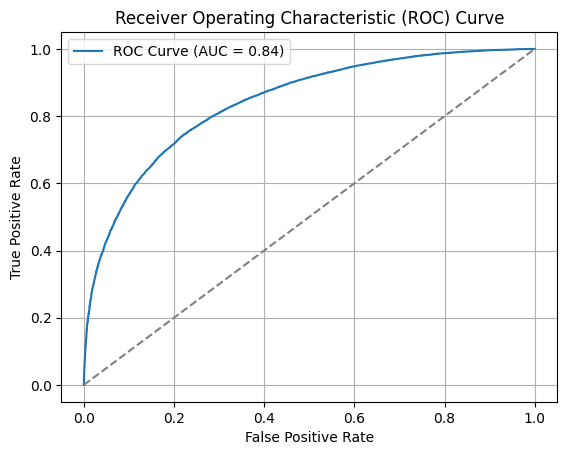

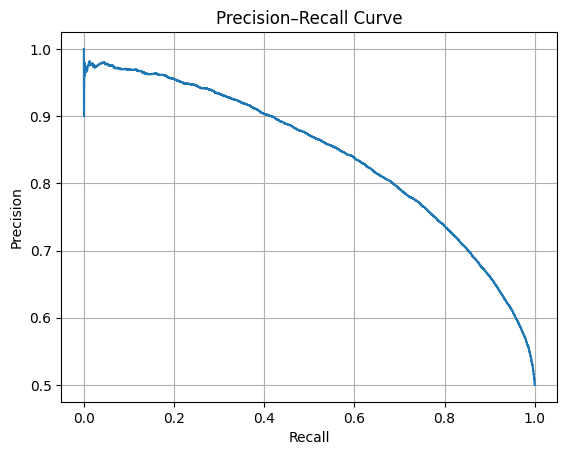

In [13]:
# Validation F1-Score and Accuracy
plt.plot(val_f1s, label='Validation F1-Score', color='purple')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score over Epochs")
plt.grid(True)
plt.legend()
plt.savefig("f1 score over epochs dimensions.png")
plt.show()

# Confusion Matrix (Final Evaluation)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, model_outputs)  # model_outputs = raw sigmoid outputs
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.grid(True)
plt.legend()
plt.savefig("roc curve")
plt.show()

# Precision - Recall Curve
precision, recall, _ = precision_recall_curve(y_true, model_outputs)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.savefig("precision recall curve")
plt.show()

In [14]:
# Prediction function for test set
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for (x_batch,) in test_loader:
            output = model(x_batch)
            preds = (output >= 0.5).long().squeeze()
            predictions.extend(preds.tolist())
    return predictions

# Make predictions
test_preds = predict(model, test_loader)

# Build submission DataFrame
submission = pd.DataFrame({
    'ID': test_ds['ID'],       # 'Id' column from test_ds
    'Label': test_preds        # Model Predictions
})

In [15]:
# Create submission file
submission.to_csv('submission.csv', index=False)
print('Submission file created: submission.csv')

Submission file created: submission.csv
